# get_history

* Chromeの履歴からYoutubeの動画情報を取得します

In [1]:
# Pythonの基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ファイル操作
import os
import glob

# 履歴データの取得
import sqlite3
from contextlib import closing
from datetime import datetime

# Jupyter上にHTMLを表示する
from IPython.display import HTML

# YoutubeAPIの利用
from apiclient.discovery import build
from apiclient.errors import HttpError

# urlの解析
from urllib.parse import urlparse

In [2]:
# Chrome履歴の取得

# ~/Library/Application\ Support/Google/Chrome/Default/History をコピーしておく
month = '202208'
db = './input/History_'+month
os.makedirs('./output/'+month, exist_ok=True)

##### IMPLEMENTATION
with closing(sqlite3.connect(db)) as conn:
    select_sql = "select visits.id, urls.url, urls.title, visits.visit_time,visits.from_visit from visits inner join urls on visits.url = urls.id"
    # select_sql = "select * from visits"
    df = pd.read_sql(select_sql, conn)

In [3]:
# visit_timeを扱いやすい形に変換
dates = np.array(df['visit_time']/1000000-11644473600)
df['visit_time_unixtime'] = dates

dates_tmp = []
for i, date in enumerate(dates):
    dates_tmp.append(str(datetime.fromtimestamp(date)))
df['visit_time_string'] = np.array(dates_tmp)

In [4]:
# 不要な情報を削除
df = df.drop(columns=['id', 'visit_time', 'from_visit'])

In [24]:
outputPath = './output/'+month+'/history.csv'
df.to_csv(outputPath, index=False)
df = pd.read_csv(outputPath)
# df.head()

In [8]:
urls = np.array(df['url'])

url_locs = []
for url in urls: 
    # URLをパースして位置を取得
    parsed_url = urlparse(url)
    url_locs.append(parsed_url.netloc)
url_locs = np.array(url_locs)

unique_url_locs, counts = np.unique(url_locs, return_counts=True)
print("uniqueな数:", counts.size)

unique_url_locs = unique_url_locs[counts >= 50]
counts = counts[counts >= 50]
# print("頻繁に訪れるサイト:", unique_url_locs)

uniqueな数: 413


In [9]:
# domainごとにdfを分割する（今回はYoutubeのみ）
df_youtube = df.query('url.str.contains("www.youtube.com")')
dfs = [df_youtube]

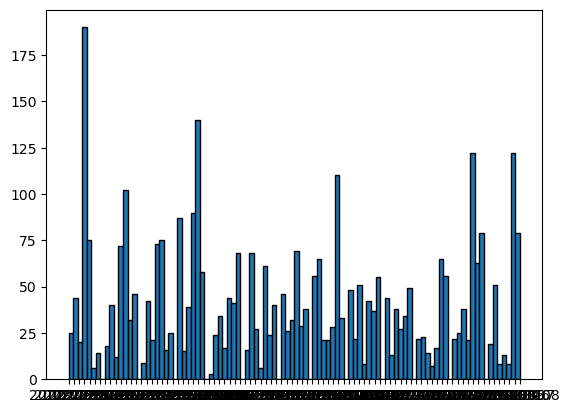

In [10]:
# histgramを作成
# おおむねdailyごとに表示したい
df_plot = dfs[0]

# 日毎の閲覧数を可視化
visit_times = np.array(df_plot['visit_time_string'])
visit_times_day = []
for visit_time in visit_times:
    visit_times_day.append(visit_time[0:10])
visit_times_day = np.array(visit_times_day)

plt.hist(visit_times_day, bins=100, ec="k")
# dfs[0]['visit_time_unixtime'].hist(bins=np.unique(visit_times_day).size)
plt.show()

# TODO: 時間と要素ごとの可視化

In [11]:
# サムネイルを表示する
def output_html(urls, top_n=10):
    if top_n <= 0:
        top_n = videos.shape[0]
        
    indexes = np.arange(urls.shape[0])[0:top_n]
    html = '<h1>動画一覧を表示</h1>'
    html += '<div style="float:left;">'
    for i in indexes:
        html += ('<img src="http://img.youtube.com/vi/'+urls[i]+'/sddefault.jpg "alt="取得できませんでした" width="200">')
        html += ('<a href="https://www.youtube.com/watch?v='+urls[i]+'">'+urls[i]+'</a><br>')
    html += '</div>'
    return html

In [15]:
# 再生数ランキング
urls_youtube = np.array(df.query('url.str.contains("https://www.youtube.com/watch?")')['url'])

video_ids = []
for url in urls_youtube:
    # &が入っていればそこまでの文字を取得
    index = url.find('&')
    if index == -1:
        video_ids.append(url[32:])
    else:
        video_ids.append(url[32:index])
video_ids = np.array(video_ids)

unique_video_ids, counts = np.unique(video_ids, return_counts=True)
# print("uniqueな動画数:", unique_video_ids.size)

ranking_idx = np.argsort(counts)[::-1]
top_n = 5
# print("ランキング:", counts[ranking_idx][0:top_n])
HTML(output_html(unique_video_ids[ranking_idx], top_n=top_n))

In [16]:
# 再生時間を取得する
visit_times_string = []
for video_id in unique_video_ids:
    df_video_id = df.query('url.str.contains("'+video_id+'")')
    visit_times_string.append(','.join(np.array(df_video_id['visit_time_string'])))

In [18]:
# Youtube APIの準備

# APIキーをファイルから取得
f = open('../secret/apikey', 'r')
api_key = f.read()
f.close()

# APIキーを用いてリクエスト用のクラスを作成
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=api_key)

In [19]:
# ISO表記の動画時間を秒に変換
def pt2sec(pt_time):
    s_list, m_list, h_list = [], [], []
    conc_s, conc_m, conc_h = '', '', ''
    flag = ''
    
    for i in reversed(pt_time):
        if i == 'S':
            flag = 'S'
        elif i == 'M':
            flag = 'M'
        elif i == 'H':
            flag = 'H'
        elif i == 'T':
            break
        else:
            if flag == 'S':
                s_list.append(i)
            elif flag == 'M':
                m_list.append(i)
            elif flag == 'H':
                h_list.append(i)
    
    for s in reversed(s_list):
        conc_s += s
    for m in reversed(m_list):
        conc_m += m
    for h in reversed(h_list):
        conc_h += h
    conc_s = 0 if conc_s == '' else int(conc_s)
    conc_m = 0 if conc_m == '' else int(conc_m)
    conc_h = 0 if conc_h == '' else int(conc_h)

    times = conc_h*3600 + conc_m*60 + conc_s
    return times

In [21]:
# 上記の動画idから新規でデータセットを作成

# 動画のIDから詳細情報を取得する
video_details = []
for i, video_id in enumerate(unique_video_ids):
    try:
        video_detail = youtube.videos().list(
            part = 'snippet,statistics,contentDetails', 
            id = video_id, 
        ).execute()
    except HttpError as e:
        print('エラーが発生しました')
        # print(e)
        break
    
    # 公開されていない動画など、取得できない場合がある
    if len(video_detail['items']) == 0:
        continue
    video_snippet = video_detail['items'][0]['snippet']
    video_statistics = video_detail['items'][0]['statistics']
    video_content_details = video_detail['items'][0]['contentDetails']
    # snippetから取得
    date = video_snippet['publishedAt']
    title = video_snippet['title']
    channel_name = video_snippet['channelTitle']
    channel_id = video_snippet['channelId']
    description = video_snippet['description']
    thumbnail = video_snippet['thumbnails']['high']['url']
    category_id = video_snippet['categoryId']
    # contentDetailsから取得
    duration = pt2sec(video_content_details['duration'])
    duration_origin = video_content_details['duration']
    # statisticsから取得
    # 評価数、コメントが非公開の場合は0で埋める
    view_count = 0
    like_count = 0
    dislike_count = 0
    comment_count = 0
    if 'viewCount' in video_statistics.keys():
        view_count = video_statistics['viewCount']
    if 'likeCount' in video_statistics.keys():
        like_count = video_statistics['likeCount']
    if 'dislikeCount' in video_statistics.keys():
        dislike_count = video_statistics['dislikeCount']
    if 'commentCount' in video_statistics.keys():
        comment_count = video_statistics['commentCount']
    # リストのリストとして情報を格納する
    video_details.append([video_id, channel_name, channel_id, date, title, 
                          thumbnail, category_id, duration, duration_origin, description, 
                          view_count, like_count, dislike_count, comment_count, 
                          counts[i], visit_times_string[i]])

video_details_numpy = np.array(video_details)
video_details_pandas = pd.DataFrame(data=video_details_numpy, 
                                    columns=['Id', 'Name', 'ChannelId', 'Date', 'Title', 
                                            'Thumbnail', 'CategoryId', 'Duration', 'DurationOriginal', 'Description',
                                            'ViewCount', 'LikeCount', 'DislikeCount', 'CommentCount', 
                                            'MyViewCount', 'VisitTimes'])

outputPath = './output/'+month+'/viewed_videos.csv'
video_details_pandas.to_csv(outputPath, index=False)

In [23]:
df_viewed = pd.read_csv(outputPath)
df_viewed.head(2)

,Id,Name,ChannelId,Date,Title,Thumbnail,CategoryId,Duration,DurationOriginal,Description,ViewCount,LikeCount,DislikeCount,CommentCount,MyViewCount,VisitTimes
0,--sIuDN8Ciw,おとうふさん@0toufusan,UCaHMd-7x6bFe-YkVSWvVPpQ,2022-04-06T17:20:03Z,オッス！オラ おかゆ！,https://i.ytimg.com/vi/--sIuDN8Ciw/hqdefault.jpg,24,5,PT5S,Sources\n【逆凸】特大ご褒美あり!?告知もあり!?イクゾ!!【 ＃猫又おかゆ3周年記...,255727,11584,0,64,1,2022-07-03 22:07:19.557396
1,--uUHn9GLUY,ヰ世界情緒 -Isekaijoucho-,UCah4_WVjmr8XA7i5aigwV-Q,2022-06-11T10:00:00Z,【歌ってみた】熱愛発覚中 / covered by ヰ世界情緒,https://i.ytimg.com/vi/--uUHn9GLUY/hqdefault.jpg,10,221,PT3M41S,わたしの好きな歌を歌います。46曲目。\n\n\nカバーさせていただきました。\n「熱愛発覚...,166063,7420,0,156,2,"2022-06-13 12:17:31.491781,2022-06-13 12:34:15..."
